# <center> HEART RATE ESTIMATION PROJECT
 **Group 5:**
    
 **Alessandro Maria Capodaglio** -  | **Marco Lorenzetti** - 
 
 **Carmen Martín Turrero** -  | **Nicolás Ortiz de Zárate** - 
 
 *08 February 2022*


In this project we consider a set of data representing linear acceleration and angular velocity measurements of the heart rate of an healthy subject, recorded using the MuSe platform, an Inertial Measurement Unit (IMU) provide by 221e.
<img src="imu.png">
The data collected by the IMU are linear acceleration, gyroscopic moment and magnetic field, in the x-y-z direction for each of the above values.
    
These data are usually used in techniques such as SCG and BCG which allow to obtain essential information on the Heart Rate (HR) and Respiratory Rate (RR). While in the SCG the sensor is placed directly on the patient's sternum (case related to the first dataset analyzed in this project) in the BCG the measurement is indirect: it can be done for example by placing the sensor under the bed on which the patient is resting
    <img src="scg_sensor.png">

These techniques are not recent, but in the past, lacking adequate technology, it has not been possible to develop them enough and has been made extensive use of invasive and expensive methods to monitor the Heart Rate. Today, with more advanced computational power, it is believed that not only is it possible to use SCG and BCG as the main methods to monitor HR in a non-invasive way, but above all to make it accessible to all at low cost, on commonly used objects.

In [1]:
# Load the required packages
import pandas as pd
import numpy as np
import scipy.linalg as la
from scipy import signal, optimize, stats
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Image
import seaborn as sns

## Data Preparation
#### Understanding and selection of the data

First of all, we need to understand the data we are working with and prepare it for our
task. The aim of this project is to compare and analyze Heart Rate of healthy subjects measured with
the MuSe platform. Therefore, we look at the available data, select the adequate
variables to study heart rate and prepare them for our study.

In [2]:
# Load the datafile
datafile = pd.read_csv('center_sternum.txt',sep='\t')

# Look what our data is like in order to select useful columns
print("The variables in our datafile are:", datafile.columns)
print("The size of our datafile is", datafile.shape)

The variables in our datafile are: Index(['Log Mode', 'Log Freq', 'Timestamp', 'AccX', 'AccY', 'AccZ', 'GyroX',
       'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ', 'qw', 'qi', 'qj', 'qk'],
      dtype='object')
The size of our datafile is (16506, 16)


Next we drop the unimportant columns, and we correct the data with the manufacturer's calibration file. Note that in the calibration matrix off-diagonal terms are very small, but non-zero. In this cell there is also the calibration for the second dataset, this is because the code we have written is very versatile: by just changing the imported filename and the calibration, the whole analysis is carried out by itself.

In [3]:
# Drop not needed columns
df = datafile.drop(['qw', 'qi', 'qj', 'qk'], axis = 1)

# Calibrate the data considering the used device
# First device cal data

gyro_offset = np.array([-2.242224,2.963463,-0.718397])

acc_calibration = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_offset = np.array([-3.929942,-13.74679,60.67546])

magn_calibration = np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_offset = np.array([-95.67974,-244.9142,17.71132])
'''
#Second device cal data
gyro_offset = np.array([-2.804399,1.793105,0.3411708])

acc_calibration = np.array([[1.002982,9.415505E-05,0.004346743],
                    [9.04459E-05, 1.002731,-0.001444198],
                    [0.004346536,-0.001444751,1.030587]])
acc_offset = np.array([3.602701,-20.96658,54.97186])

magn_calibration = np.array([[1.013437,-0.04728858,-0.001861475],
                   [-0.04728862,1.004832,0.008222118],
                   [-0.001861605,0.008221965,0.9439077]])
magn_offset = np.array([-150.4098,74.62431,630.9805])
'''
# Calibration
df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_offset.T
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']],acc_calibration.T) + acc_offset.T
df[['MagnX','MagnY','MagnZ']] = np.dot(df[['MagnX','MagnY','MagnZ']],magn_calibration.T) + magn_offset.T

#Add time column by taking time steps of 1/logFreq
df['Time'] = np.arange(0, len(df['Log Freq']))/df['Log Freq'][0]
display(df)

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
0,5,200,1576222772,943.007996,410.325442,130.264244,-9.066652,-11.280817,0.686183,-502.261441,-683.404962,-141.669690,0.000
1,5,200,1576222772,965.209969,363.380701,148.635086,3.940982,-9.326617,-8.687863,-502.257960,-683.400705,-140.794890,0.005
2,5,200,1576222772,985.689106,356.065246,138.465450,9.467696,-1.998369,-8.168779,-502.257960,-683.400705,-140.794890,0.010
3,5,200,1576222772,950.852176,393.026437,148.047237,15.635636,5.482547,-6.703130,-502.207976,-685.226199,-139.928605,0.015
4,5,200,1576222772,968.040164,402.461108,159.595720,22.979146,8.368043,3.296870,-502.207976,-685.226199,-139.928605,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,954.849739,269.000099,5.047576,-0.578102,5.268807,-1.390153,-539.805161,-644.743591,-96.144764,82.505
16502,5,200,1576222847,951.006879,266.016847,9.709647,-0.761308,5.452013,-1.420687,-539.778428,-645.654210,-95.274222,82.510
16503,5,200,1576222847,963.711402,268.397270,-4.573267,-1.127720,6.337509,-1.619160,-539.778428,-645.654210,-95.274222,82.515
16504,5,200,1576222847,961.972293,278.538659,3.067677,-1.539934,6.627585,-2.306183,-540.740736,-643.796949,-94.394388,82.520


#### Plotting the data and choosing a time frame

In order to analyze the data we need to pick a time frame. By inspection we have found that at the beginning of the data acquisition and towards the end the data is very noisy. So we have selected a time frame in the middle.

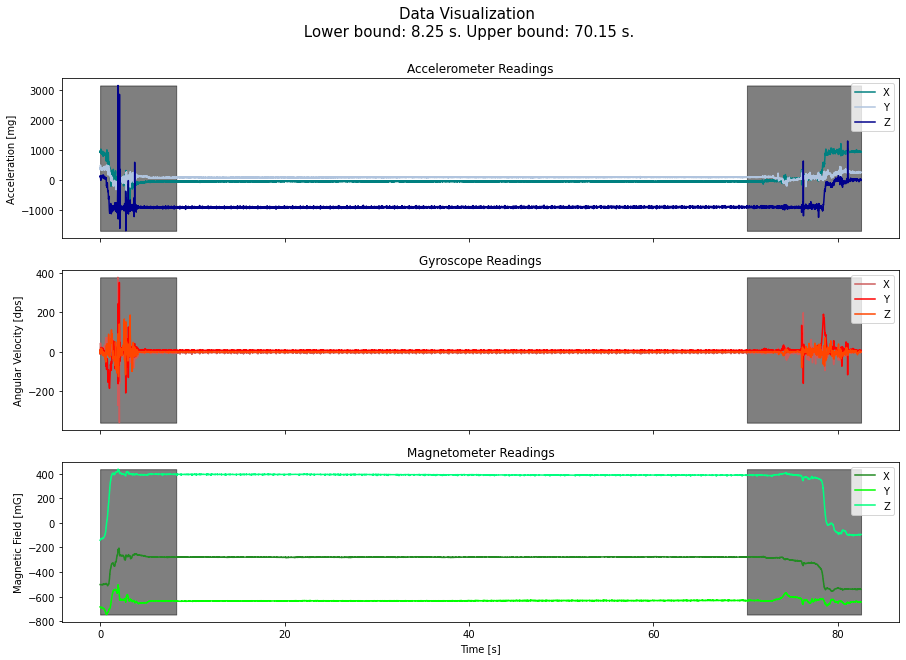

In [4]:
# Look at the data and trim 10% on the lower end and 15% on the upper one (limits have been chosen according to the plots)

lowlimit = df['Time'][int(0.1*len(df['Time']))]
highlimit = df['Time'][int(0.85*len(df['Time']))]

(fig, axs) = plt.subplots(3,1,figsize=(15,10), sharex=True)

fig.suptitle(f'Data Visualization\n Lower bound: {lowlimit} s. Upper bound: {highlimit} s.', fontsize = 15)

axs[0].set_title('Accelerometer Readings')
axs[0].plot(df['Time'], df['AccX'], color= 'teal',label='X')
axs[0].plot(df['Time'], df['AccY'], color= 'lightsteelblue',label='Y')
axs[0].plot(df['Time'], df['AccZ'], color= 'darkblue',label='Z')
# axs[0].axvline(x = lowlimit, color = 'red', alpha = 0.5)
# axs[0].axvline(x = highlimit, color = 'red', alpha = 0.5)
axs[0].set_ylabel('Acceleration [mg]')
axs[0].fill_between(df.Time[df['Time']<=lowlimit], min(df['AccZ']), max(df['AccZ']), color = 'black', alpha = 0.5)
axs[0].fill_between(df.Time[df['Time']>=highlimit], min(df['AccZ']), max(df['AccZ']), color = 'black', alpha = 0.5)
axs[0].legend()

axs[1].plot(df['Time'], df['GyroX'],color = 'indianred', label='X')
axs[1].plot(df['Time'], df['GyroY'],color = 'red' , label='Y')
axs[1].plot(df['Time'], df['GyroZ'],color = 'orangered' , label='Z')
axs[1].set_title('Gyroscope Readings')
# axs[1].axvline(x = lowlimit, color = 'red', alpha = 0.5)
# axs[1].axvline(x = highlimit, color = 'red', alpha = 0.5)
axs[1].set_ylabel('Angular Velocity [dps]')
axs[1].fill_between(df.Time[df['Time']<=lowlimit], min(df['GyroX']), max(df['GyroX']), color = 'black', alpha = 0.5)
axs[1].fill_between(df.Time[df['Time']>=highlimit], min(df['GyroX']), max(df['GyroX']), color = 'black', alpha = 0.5)
axs[1].legend()

axs[2].plot(df['Time'], df['MagnX'],color = 'forestgreen' , label='X')
axs[2].plot(df['Time'], df['MagnY'], color = 'lime', label='Y')
axs[2].plot(df['Time'], df['MagnZ'], color = 'springgreen', label='Z')
axs[2].set_title('Magnetometer Readings')
# axs[2].axvline(x = lowlimit, color = 'red', alpha = 0.5)
# axs[2].axvline(x = highlimit, color = 'red', alpha = 0.5)
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Magnetic Field [mG]')
axs[2].fill_between(df.Time[df['Time']<=lowlimit], min(df['MagnY']), max(df['MagnZ']), color = 'black', alpha = 0.5)
axs[2].fill_between(df.Time[df['Time']>=highlimit], min(df['MagnY']), max(df['MagnZ']), color = 'black', alpha = 0.5)
axs[2].legend()
plt.show()

#### Limit time between thresholds

We apply the threshold on the dataframe.

In [5]:
# Cut the misleading rows by trimming the data based on time
df_timecut = df.loc[(df['Time'] >= lowlimit) & (df['Time'] <= highlimit)] #limit analysis to the specified time frame

# Select the columns we need for the PCA, drop the unimportant ones
df_time_frame = df_timecut.drop(['Log Mode', 'Log Freq', 'Timestamp', 'Time'], axis=1)
display(df_time_frame)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
1650,-37.476891,102.563273,-907.655555,-4.501766,6.215371,-1.573359,-278.899995,-637.942189,393.901226
1651,-39.855996,103.053747,-912.431818,-5.539934,6.810791,-1.405420,-278.943017,-636.108179,394.784542
1652,-36.491725,105.399753,-929.035450,-6.043751,7.345143,-1.313817,-278.943017,-636.108179,394.784542
1653,-47.111798,92.350697,-890.606398,-6.089552,7.314608,-0.672595,-278.966269,-635.193303,394.788799
1654,-35.935845,96.230388,-906.972954,-6.196423,7.375677,-0.458855,-278.966269,-635.193303,394.788799
...,...,...,...,...,...,...,...,...,...
14026,-46.603314,113.623834,-904.236820,-9.524667,4.902394,-2.199313,-277.221820,-632.524980,388.684933
14027,-39.727249,109.294866,-855.912008,-11.112453,5.528349,-2.168779,-276.279283,-633.463108,388.684157
14028,-46.933633,107.748107,-848.555029,-9.371995,6.612318,-2.107710,-276.279283,-633.463108,388.684157
14029,-53.106252,109.190281,-845.306946,-6.410163,7.818425,-1.390153,-277.198568,-633.439856,388.680676


## STATISTICAL QUANTITIES

Find statistical quantities and use them to center our data in order to perform a PCA.

We can now analyze the data. This is standard practice, we have decided to put the data into a dataframe, instead of just the standard "describe" method, because we will then standardize the data (by subtracting the mean and dividing by the standard deviation).

Statistics of the data set


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
mean,-34.313318,100.845493,-892.569491,-4.331309,6.645650,-1.584158,-278.656348,-633.691478,391.146106
median,-34.259900,100.989385,-892.968158,-4.394896,6.597051,-1.573359,-278.962788,-633.412347,391.285341
variance,49.486769,27.420896,212.043834,2.060900,0.524829,0.134298,1.448028,3.114447,6.658165
standard deviation,7.034683,5.236497,14.561725,1.435583,0.724451,0.366467,1.203340,1.764780,2.580342
25% percentile,-38.949126,97.422824,-901.281989,-4.929247,6.230639,-1.817634,-279.090603,-635.178566,388.689191
75% percentile,-29.616485,104.316631,-884.678736,-3.723140,6.963463,-1.344351,-278.046984,-632.474220,393.906260


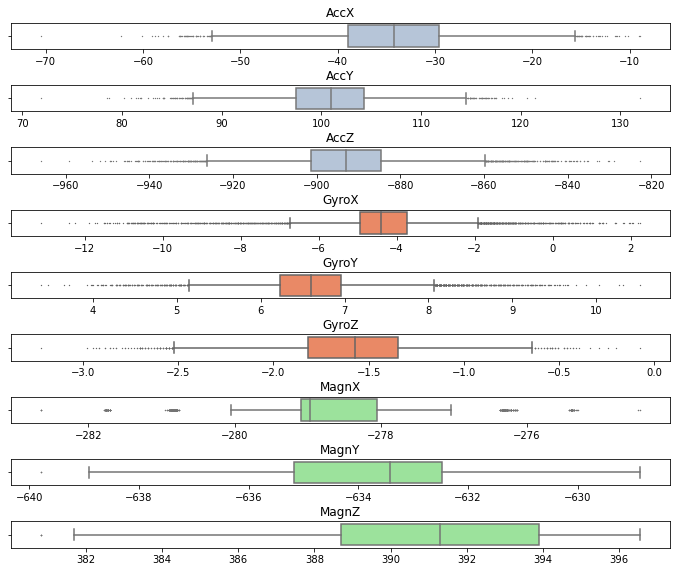

In [6]:
statistics = pd.DataFrame({
    'mean'  : df_time_frame.mean(),
    'median': df_time_frame.median(),
    'variance': df_time_frame.var(),
    'standard deviation': df_time_frame.std(),
    '25% percentile' : df_time_frame.quantile(q=0.25),
    '75% percentile': df_time_frame.quantile(q=0.75)}).T

print('Statistics of the data set')
display(statistics)

colors = ['lightsteelblue', 'coral', 'lightgreen']
fig, ax = plt.subplots(9,1, figsize=(10, 8))
fig.tight_layout(pad=1.5)
for i,feature in zip(range(len(df_time_frame.columns)),df_time_frame.columns):
#     ax1.boxplot(df_time_frame)
#     ax[i].set_title(feature)
#     box = ax[i].boxplot(df_time_frame[[feature]], showfliers=False, notch=True, vert=True)
    if i<3: ind=0
    elif i<6 and i>=3: ind=1
    else: ind=2
    sns.boxplot(ax=ax[i], x=df_time_frame[feature], color=colors[ind], fliersize=0.5).set(title=feature)
    ax[i].set(xlabel=None)
plt.show()


In [7]:
# Center the data
centered_df = (df_time_frame - statistics.iloc[0])

# Normalize the data
standardized_df = centered_df/statistics.iloc[3]

print('Standardized Data')
display(standardized_df)

Standardized Data


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
1650,-0.449711,0.328040,-1.036008,-0.118737,-0.593938,0.029470,-0.202476,-2.408635,1.067734
1651,-0.787907,0.421705,-1.364009,-0.841905,0.227953,0.487734,-0.238228,-1.369407,1.410059
1652,-0.309667,0.869715,-2.504233,-1.192854,0.965549,0.737696,-0.238228,-1.369407,1.410059
1653,-1.819340,-1.622229,0.134812,-1.224758,0.923399,2.487433,-0.257551,-0.850999,1.411709
1654,-0.230647,-0.881334,-0.989132,-1.299203,1.007696,3.070678,-0.257551,-0.850999,1.411709
...,...,...,...,...,...,...,...,...,...
14026,-1.747058,2.440246,-0.801233,-3.617594,-2.406313,-1.678607,1.192122,0.660988,-0.953817
14027,-0.769605,1.613555,2.517386,-4.723615,-1.542273,-1.595287,1.975389,0.129404,-0.954118
14028,-1.794013,1.318174,3.022613,-3.511246,-0.046010,-1.428644,1.975389,0.129404,-0.954118
14029,-2.671468,1.593582,3.245669,-1.448090,1.618846,0.529394,1.211444,0.142580,-0.955467


## PCA

As we have a large amount of data features, we perform a Principal Component Analysis to
get the lowest dimension dataset possible without missing important information. We start by studying the covariance
matrix of the data.

In [8]:
# Covariance matrix of the data
cov = np.cov(standardized_df.T) 
print('Covariance matrix is: \n')
print(cov)

# Eigenvalues and eigenvectors of covariance matrix
l, V = la.eig(cov)
print('\n')

# Study most important variances in the dataset
print('Eigenvector and eigenvalue analysis:\n')
var = []
for i in range(len(l)):
    var.append(np.real_if_close(l[i]/l.sum()))
for i in range(len(var)):
    print('eigVec', V[:,i], 'with eigenvalue', np.round(np.real_if_close(l[i]),5), 'accounts for', np.round(var[i]*100,5), '% of the dataset variance.')

Covariance matrix is: 

[[ 1.         -0.18010652 -0.40684445  0.2071927   0.00827065  0.02497423
  -0.38367823 -0.02537724  0.0747912 ]
 [-0.18010652  1.          0.16840543 -0.05379475 -0.00833644 -0.14244271
   0.24035145  0.35395883 -0.48795478]
 [-0.40684445  0.16840543  1.         -0.08043832  0.11577611  0.01927046
   0.11970488  0.19965284 -0.24294729]
 [ 0.2071927  -0.05379475 -0.08043832  1.          0.40355401  0.3901244
  -0.06008825 -0.05702054  0.02488998]
 [ 0.00827065 -0.00833644  0.11577611  0.40355401  1.          0.43688409
   0.01007242 -0.13008042  0.02667903]
 [ 0.02497423 -0.14244271  0.01927046  0.3901244   0.43688409  1.
  -0.0152078  -0.07247408  0.01869308]
 [-0.38367823  0.24035145  0.11970488 -0.06008825  0.01007242 -0.0152078
   1.          0.2212077  -0.31159662]
 [-0.02537724  0.35395883  0.19965284 -0.05702054 -0.13008042 -0.07247408
   0.2212077   1.         -0.74322389]
 [ 0.0747912  -0.48795478 -0.24294729  0.02488998  0.02667903  0.01869308
  -0.311

Now we rotate the data in the new base, thus taking a linear combination of physical quantities.
The goal here is to then reduce the number of principal components, by setting a threshold on the total amount of variance that we want to retain.

In [9]:
# Order eigenvalues and eigenvectors according to variance importance
idx = np.argsort(l)[::-1]  # sort the eigenvalues and eigenvectors
l_sort = l[idx]
V_sort = V[idx]
tr = l.sum()

# Rotate the dataset to the base of eigenvalues and eigenvectors
rotated_data = np.dot(V.T, standardized_df.T) #bring the dataset in the eigenvector basis

# Create an array with the Principal Components of the dataset
PC_names = []
for i in range(1,len(l_sort)+1): PC_names.append(f"PC{i}")
    
dataset_rotated = pd.DataFrame(rotated_data.T, columns = PC_names)

# Store the weights value of each PC in a dictionary
weights = dict()
i = 0
for PC in PC_names:
    weights[PC] = np.real_if_close(l_sort[i]/tr)
    i += 1

# Find out how many columns of the PCA we can drop while keeping 80% of the info
S, j = 0, 0
while S < 0.8:
    S += weights[PC_names[j]]
    j += 1
info_PC = S
n_PC = j
print("Reduction of the number of PC and its accuracy:")
print(np.round(info_PC*100, 2), '%, number of PC = ', n_PC)
print(weights)

Reduction of the number of PC and its accuracy:
80.89 %, number of PC =  5
{'PC1': array(0.27805573), 'PC2': array(0.19878023), 'PC3': array(0.15245001), 'PC4': array(0.09816959), 'PC5': array(0.08146999), 'PC6': array(0.06315282), 'PC7': array(0.05846528), 'PC8': array(0.04405207), 'PC9': array(0.02540427)}


We now drop the principal components that are not needed.

In [10]:
# With the results, we can lower the number of variables to n_PC
dataset_rotated = dataset_rotated.drop(PC_names[n_PC:], axis = 1)
display(dataset_rotated)

,PC1,PC2,PC3,PC4,PC5
0,1.685239,-0.955760,-1.013715,0.754276,-1.014271
1,1.388061,-0.618198,-1.065919,-0.213701,-0.998374
2,1.731896,-0.392483,-0.408007,-0.336534,-1.678237
3,1.609219,0.829762,-2.686721,-0.332564,0.210873
4,2.156733,1.019641,-1.144500,-0.551991,-0.466820
...,...,...,...,...,...
12376,-3.684263,-3.776254,-0.555251,0.038279,-1.247281
12377,-4.137528,-3.313988,-2.113312,0.145135,0.623236
12378,-4.016005,-1.650090,-2.997731,0.180835,0.827152
12379,-3.300205,1.466948,-3.348192,0.103097,1.227406


## FREQUENCY ANALYSIS

Once we have our data prepared for working, we start by studying its frequency.
This gives us an idea of the frequency domain of the Heart Beat. Note that this is only to give us an idea, the next sections will deal with cleaning up the noise through various techniques, i.e.: bandpass and wavelet decomposition. 

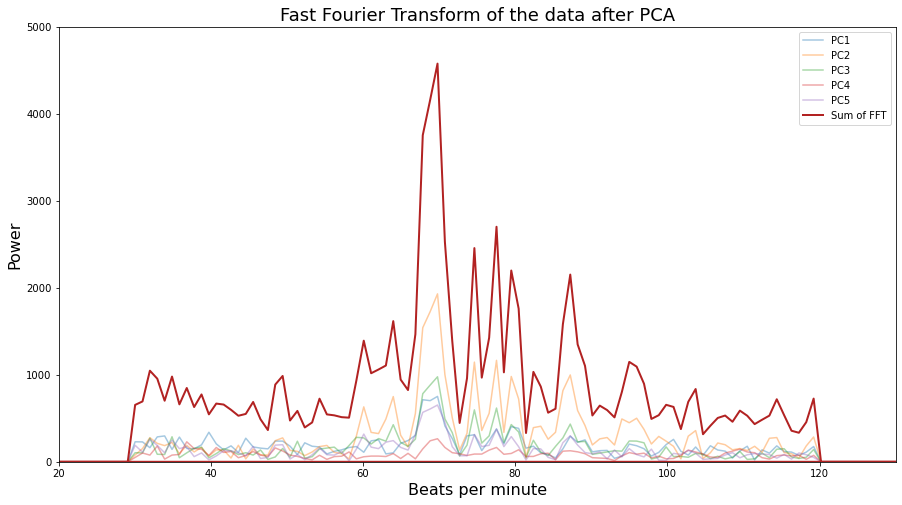

Highest peak is at: 69.78 beats per minute


In [11]:
sample_freq = 200

# FFT
FFTs = {} # create a dictionary to store the FFT of each PC
for i in dataset_rotated:
    FFTs[i] = np.abs(np.fft.fft(dataset_rotated[i]))

freq_FFT = np.fft.fftfreq(d = 1/sample_freq, n = len(dataset_rotated['PC1']))

# Set frequency limits
min_f = 30/60  #minimum for athletes is 30 beats per minute
max_f = 120/60 #maximum (sustainable) is around 120 beats per minimum
for i in FFTs:
    FFTs[i][freq_FFT <= min_f] = 0
    FFTs[i][freq_FFT >= max_f] = 0

# As each PC gives the frequencies of the heartbeat, we can sum all of them (weighted) to get a better idea of the
# heart rate of the subject
total_FFT = np.zeros(len(FFTs['PC1']))
for i in FFTs:
    total_FFT += FFTs[i]

# Plot the frequencies
frequencies_fig = plt.figure(figsize=(15, 8))
for i in FFTs:
    plt.plot(freq_FFT*60, FFTs[i], label=i, alpha = 0.4)
plt.plot(freq_FFT*60, total_FFT, label='Sum of FFT', color = 'firebrick', linewidth = 2)
plt.xlim([min_f*60-10, max_f*60+10])
plt.ylim([0, 5000])
plt.xlabel('Beats per minute', fontsize = 16)
plt.ylabel('Power', fontsize = 16)
plt.title('Fast Fourier Transform of the data after PCA', fontsize = 18)
plt.legend()
plt.show()

# Find the value of the highest peak
idx_max = np.argmax(total_FFT)
peak_freq = freq_FFT[idx_max]*60
print("Highest peak is at:", np.round(peak_freq,2), "beats per minute")

## FILTER

As we can see from observing the data in the frequency domain, the subject heart rate primarilly ranges from about 60 to 100 beats per minute.

The goal now is to filter the data to get a clearer view of these heart rate values, and
to analyze them with respect to time. To do so, we have implemented a simple filter pipeline consisting of a butterworth bandpass filter, followed by a wavelet filter. Each principal component signal is passed through the filter, and a filtered signal is returned. 

#### Butterworth bandpass filter

First, we define and use a butterworth bandpass. The scipy function takes a signal as input and returns a filtered signal according to the parameters specified. Using the observations from the fourier analysis we set the frequencies at 50bpm and 100bpm as the critical frequencies.

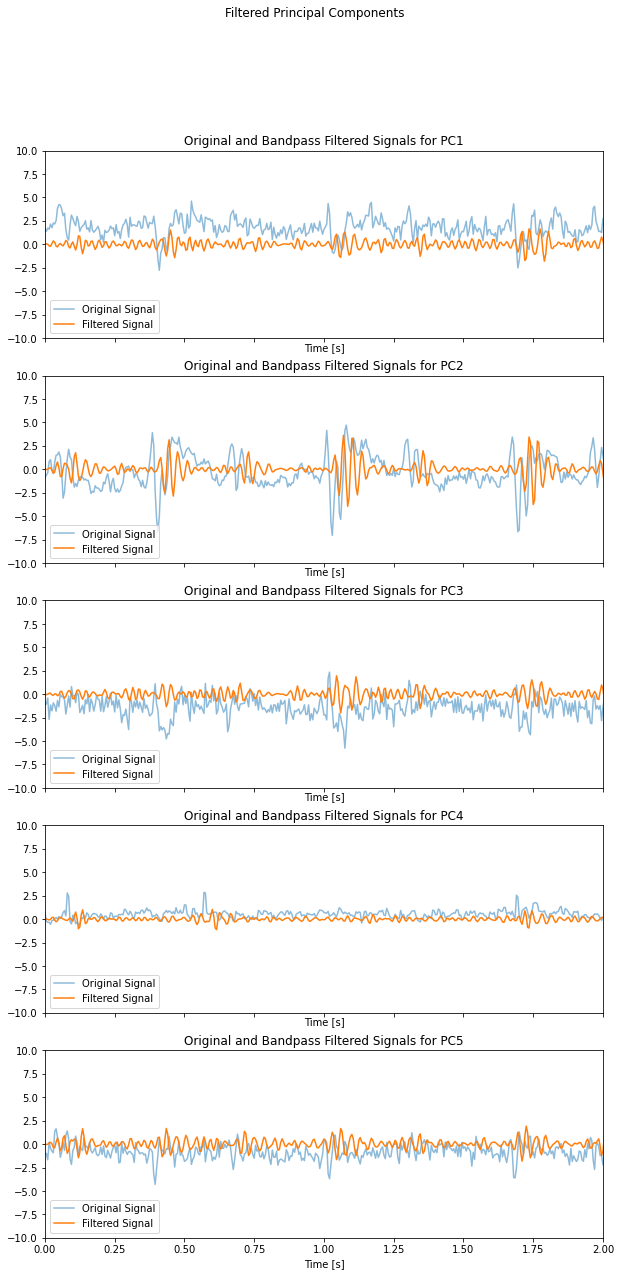

In [12]:
# Add a time column to the dataframe
dataset_rotated['Time'] = np.arange(0, len(dataset_rotated['PC1']))/sample_freq

# butterworth bandpass filter
sos = signal.butter(4, [50,100], 'bp', fs = 400, output = 'sos')

# Filter each PC signal and add to dictionary to visualize
filtered_PCs = dict()
for i in FFTs:
    filtered_PCs[i] = signal.sosfilt(sos, dataset_rotated[i])

# Plot and visualize results of the bandpass filter
fig, axs = plt.subplots(n_PC,1, sharex=True, sharey=True, figsize=(10,20))
fig.suptitle('Filtered Principal Components')
ax = 0
for i in filtered_PCs:
    axs[ax].plot(dataset_rotated['Time'], dataset_rotated[i], alpha = 0.5, label='Original Signal')
    axs[ax].plot(dataset_rotated['Time'], filtered_PCs[i], label='Filtered Signal')
    axs[ax].set_title(f'Original and Bandpass Filtered Signals for {i}')
    axs[ax].legend(loc="lower left")
    axs[ax].set_xlim([0,2])
    axs[ax].set_ylim([-10,10])
    axs[ax].set_xlabel('Time [s]')
    ax += 1

#### Wavelet transform

This function takes as input the signal to be decomposed, the amount of levels for which it should be decomposed, the signal type to be used for the wavelet decomposition and a boolean variable to determine if the breakdown of the wavelet levels should be shown.

The basic idea of the wavelet transform is to decompose a signal into a set of wavelets, sliding each wavelet scale across the signal, and determining how much of each respective scale is in the signal. What is returned in the decomposition is a list of coefficients, with the coefficients being related to the 'similarity' of the input signal and the chosen wavelet type. 

In general, the lower levels of the wavelet decomposition correspond to higher frequencies and high levels correspond to low frequencies. We chose use the sym4 wavelet type ad to have 6 levels of wavelets, eventually filtering the lower and upper levels.

In [13]:
import pywt # PyWavelets is open source wavelet transform software for Python
import copy

def wavelet_transform(signal, levels, waveletType, showWaveletScales):
    # Decompose signal
    transformCoeffs = pywt.wavedec(signal, waveletType, level=levels)
    
    # The following is purely for visualization purposes! 
    
    # Create a time array and a result array to visualize the layers
    time = np.array(dataset_rotated['Time'])
    result = np.zeros((levels+1, len(time)+1))
    
    for i in range(levels+1):
        # Loop for every individual layer to get the coefficients of just that level
        coeffs = copy.deepcopy(transformCoeffs)
        
        for j in range(levels+1):
            # Loop over every other level and set to zero, we want to ignore all other levels
            if(i!=j):
                coeffs[j] = np.zeros_like(coeffs[j])
        
        #add the inverse wavelet of the level i to the corresponding result row
        result[i] = pywt.waverec(coeffs, waveletType)
        
    # Option to visualize the wavelet scale decomposition
    if showWaveletScales == True:
        for level in range(levels+1):
            # Plot each level
            plt.figure(figsize=(15, 5))
            plt.plot(time, result[level][:-1])
            plt.title(f'Wavelet Transform of Signal, level {level}')
            plt.xlabel('Time')
            plt.xlim(30, 35)
            plt.show()
    
    return transformCoeffs

#### Visualization of the Wavelet Transform

Here is a sample image of what a typical heartbeat signal looks like

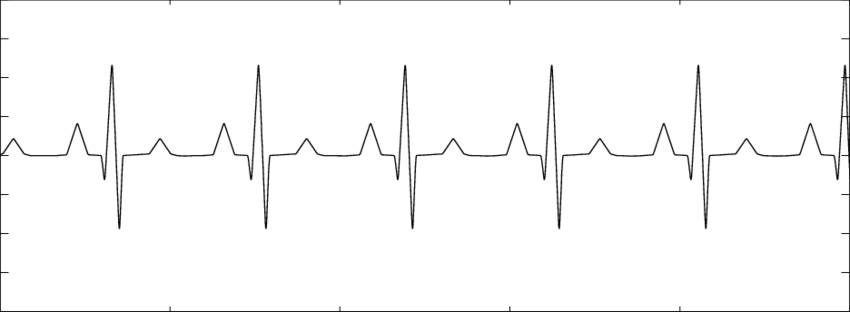

In [14]:
Image('Sample_heartbeat_image.png')
# Source: https://www.researchgate.net/figure/Maternal-heartbeat-signal_fig1_265696265

Here are the different "symlet" types. As we can see comparing the "typical" form of a heartbeat, the sym4 wavelet shape is most characteristic of a heartbeat signal. 

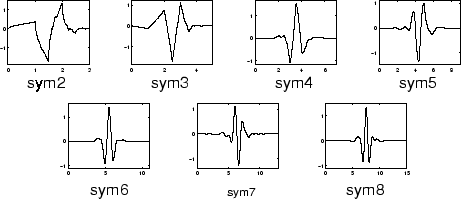

In [15]:
Image('symlets.gif')
# Source: https://www.mathworks.com/help/wavelet/gs/introduction-to-the-wavelet-families.html

Here is an example of what the wavelet decomposition looks like when run on an unfiltered signal, in this case that of PC2.

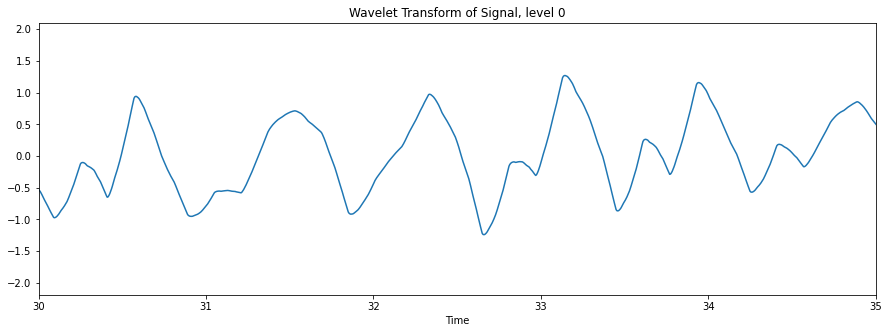

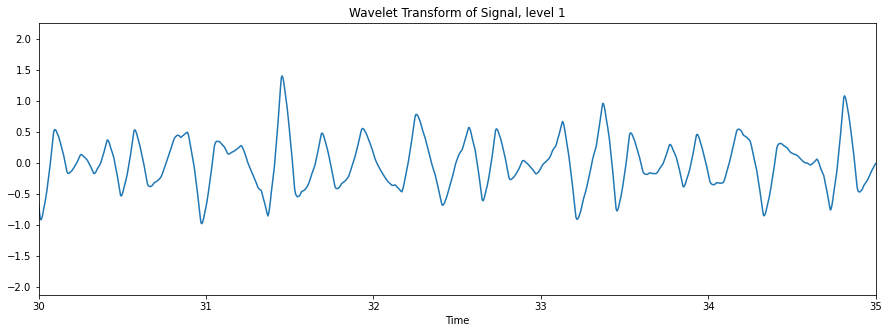

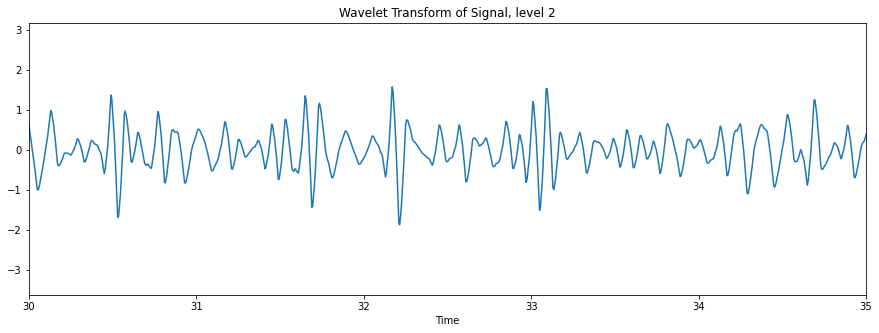

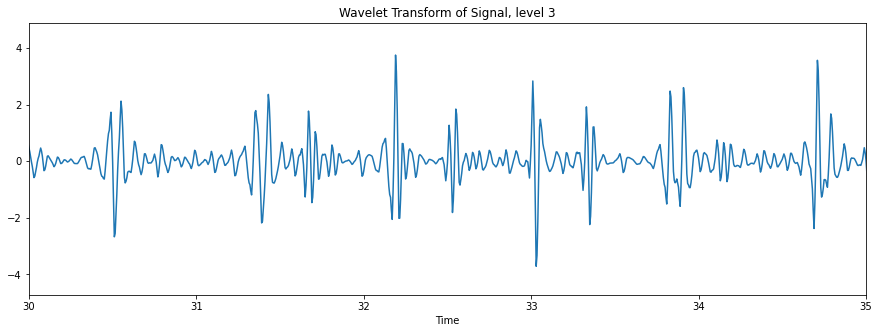

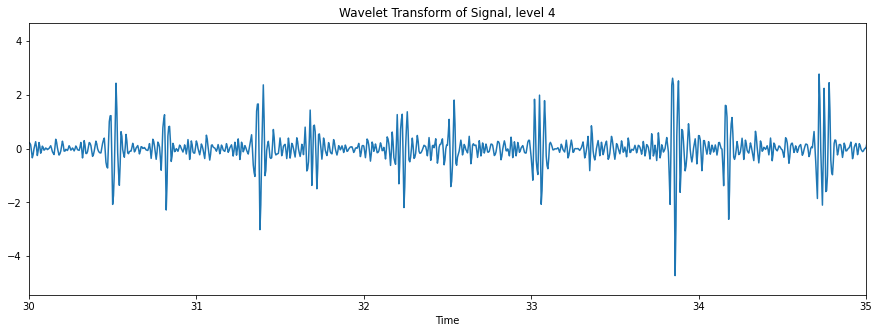

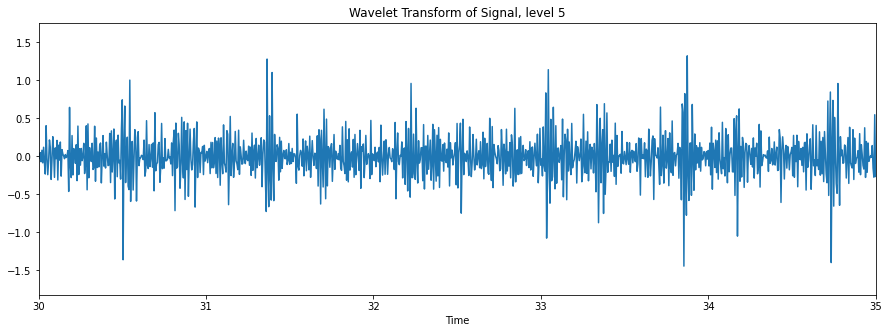

In [16]:
waveletDemo = wavelet_transform(dataset_rotated['PC2'], 5, 'sym4', True)

#### Wavelet Filter

The following function is the actual wavelet filter, which receives the coefficients generated from the wavelet transform, the indices of the wavelet scales that we wish to filter out, and the signal type used in the decomposition. It returns the wavelet recomposition (inverse of the original decomposition) with the layers omitted in the indices parameter set to zero. 

From cardiography, wavelet literature, and the above visualizations of the wavelet decomposition, we chose to use only the level 3 when reconstructing our signal, and filtered the rest of the levels.

In [17]:
def waveletFilter(coeffs, indices, waveletType):
    for level in range(len(coeffs)):
        # Set every level in the indices parameter to zero
        if level in indices:
            coeffs[level] = np.zeros_like(coeffs[level])
    # Return the reconstructed signal
    return pywt.waverec(coeffs, waveletType)

#### Filter Pipeline

Finally, we compiled the bandpass and wavelet functions into one filter pipeline that receives a signal and passes it through first the bandpass function and then the wavelet functions, and returns a filtered signal in the time domain. 

In [18]:
def filterSignal(sig):

    # Passes a signal through a bandpass and wavelet filter and returns the filtered signal
    bandpass = signal.sosfilt(sos, sig)
    wavelet = wavelet_transform(np.array(bandpass), 5, 'sym4', False)
    wavelet_filtered = waveletFilter(wavelet, [0,1,2,4,5], 'sym4')

    return wavelet_filtered[:-1]

#### Filtering the Signals

With the filter pipeline, we now create a dictionary and pass each principal component signal through the pipeline. We then assign the filtered signal to the corresponding principal component key and visualize the results.

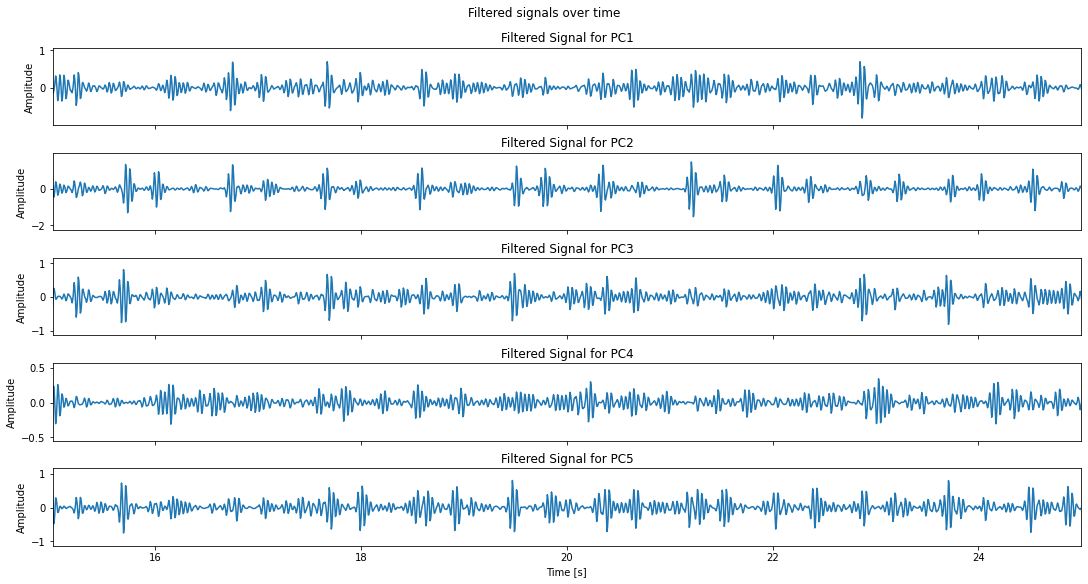

In [19]:
# Apply the filters to the data
PCs = dict()
for i in FFTs:
    # Assign the filtered signal to each principal component
    PCs[i] = filterSignal(dataset_rotated[i])

# Plot each filtered signal
(fig, axs) = plt.subplots(n_PC,1,figsize = (15,8), sharex=True, constrained_layout=True)
fig.suptitle('Filtered signals over time')
plt.xlabel('Time [s]')
plt.xlim(15, 25)
ax = 0
for i in PCs:
    axs[ax].plot(np.array(dataset_rotated['Time']), (PCs[i]), label=i)
    axs[ax].set_title(f'Filtered Signal for {i}')
    axs[ax].set_ylabel('Amplitude')
    ax += 1
plt.show()

# METRICS

#### Heart Beat Per Minute(BPM) and Heart Rate Variability (HRV)

In order to find out the heart rate of the subject over time, we need to analyze the filtered
signal. As seen before, after the filter, the signals have clear peaks, which correspond to heart beats.
Distance between peaks in the time domain provides the
frequency of the heart beat for each moment of time. We measure the peak location
by taking the absolute value of the signal.

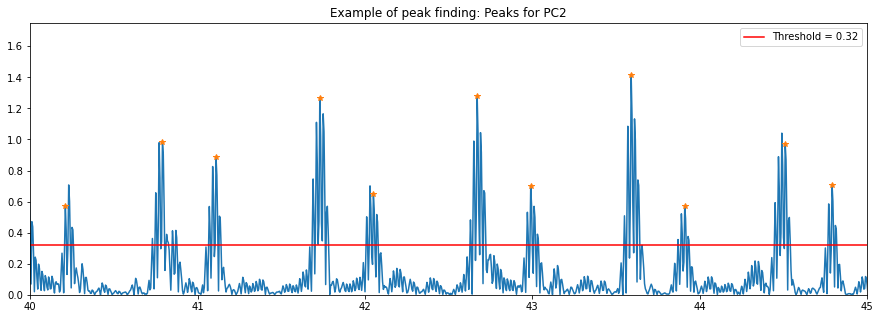

In [20]:
# Find the peaks in the filtered data
# scipy function find_peaks finds indexes of the peaks when provided:
# height: minimum height of a measured peak
# distance: minimum number of indexes between measured peaks

# Function for, given the peak indexes, finding corresponding time and height
def peak_points(indices, time, signl):
    x_peaks = []
    y_peaks = []
    for i in indices:
        x_peaks.append(time[i])
        y_peaks.append(signl[i])
    return np.array(x_peaks), np.array(y_peaks)

# Store the time each heart beat happens for each PC
PC_times = dict()
PC_peaks = dict()
for i in PCs:
    # Threshold for not measuring noise peaks
    lorenzetti = np.sum(np.abs(PCs[i])**(1/2))/(len(PCs[i]))
    
    # Find peaks of the signal and their times
    peaks = signal.find_peaks((PCs[i]), height =lorenzetti, distance = 40)
    time_PC, peaks_PC = peak_points(peaks[0], np.array(dataset_rotated['Time']), PCs[i])
    
    #Store the times of the peaks
    PC_times[i] = time_PC
    PC_peaks[i] = peaks_PC

# Example plot of the peak finding
plt.figure(figsize=(15,5))
plt.plot(np.array(dataset_rotated['Time']), np.abs(PCs['PC2']))
plt.plot(PC_times['PC2'], PC_peaks['PC2'], '*')
plt.axhline(np.sum(np.abs(PCs['PC2'])**(1/2))/(len(PCs['PC2'])),color='red', label = f'Threshold = {np.round(np.sum(np.abs(PCs["PC2"])**(1/2))/(len(PCs["PC2"])),2)}')
plt.ylim([0, 1.75])
plt.xlim([40,45])
plt.title(f'Example of peak finding: Peaks for PC2')
plt.legend()
plt.show()


In the following code, we analyze the Heart Rate over time for each of the Principal Components.
With the results, we build a histogram for each of them to see more clearly
the distribution of Heart Beat. Finally, we elaborate a histogram gathering all the data and
taking into account the importance of each PC (i.e. their weights).

An important measure besides Heart Rate is Heart Rate Variability. It measures the amount of
variation that exists on the Heart Rate, this is how much the heart beat varies from beat to beat.
It is commonly measured with the Root Mean Square of Successive Differences (RMSSD). We will use this technique
for each PC and provide a final HRV by doing a weighted average of the results.

In [21]:
# Filter the points that are valuable and estimate the periodicity between peaks
# highest possible frequency = 120bpm, therefore it is only reasonable
# that there is a peak at least every 1/120*60 seconds = 0.5s

# This function makes sure of the above
def time_frame(t, a, b):
    # break if it is out of bounds of time
    if b > (len(t)-1): return 1, 0
    measure = (t[b] - t[a])
    if measure > 0.5:
        return measure, b
    else:
        b += 1
        return time_frame(t, a, b)

def heartbeat(times):
    # Takes in times of the peaks, and returns the heartbeat values, the
    # times of the heartbeats and HRV
    periodicity = []
    time_beat = []
    b = 0
    for i in range(len(times)):
        if i == b:
            p, b = time_frame(times, i, (i+1))
            # According to Fourier freq analysis: BPM is between 40 and 110
            if 40 < (1/p*60) < 110:
                periodicity.append(p)
                time_beat.append((times[b]+times[i])/2)
    periodicity.pop()
    time_beat.pop()
    # HRV
    diff = []
    for a in range(len(periodicity)-1):
        diff.append(periodicity[a+1]-periodicity[a])
    rmssd = np.sqrt(np.mean(np.square(diff)))
    # HBR
    HB_values = 1/np.array(periodicity)*60
    return HB_values, time_beat, rmssd

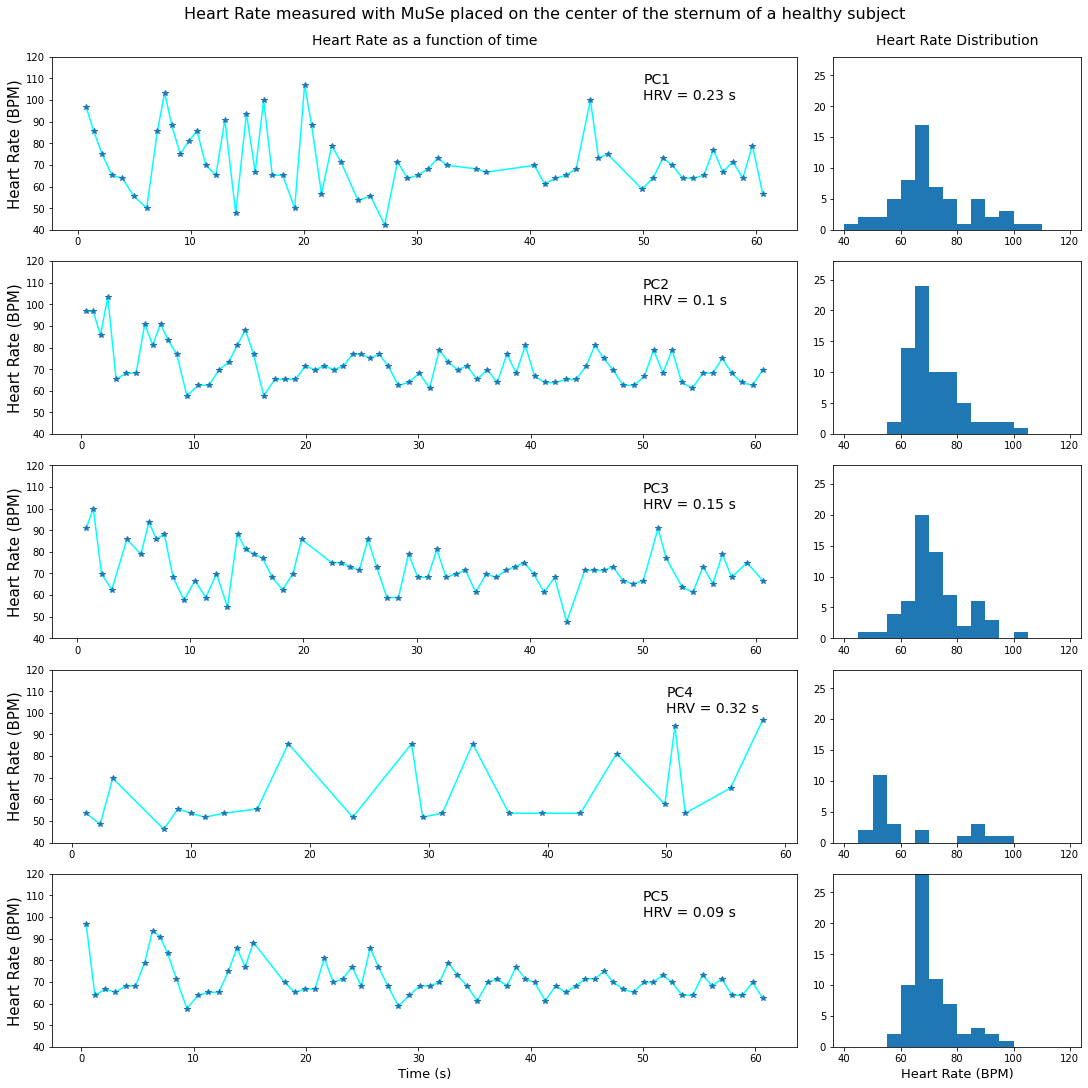

In [22]:
# Plot the results
fig, axs = plt.subplots(n_PC, 2, figsize = (15, 15), gridspec_kw={'width_ratios': [3, 1]}, constrained_layout=True)
plt.suptitle('Heart Rate measured with MuSe placed on the center of the sternum of a healthy subject', fontsize = 16)
axs[n_PC-1,0].set_xlabel('Time (s)', fontsize = 13)
axs[n_PC-1,1].set_xlabel('Heart Rate (BPM)', fontsize = 13)
axs[0,0].set_title('Heart Rate as a function of time', fontsize = 14, pad = 12)
axs[0,1].set_title('Heart Rate Distribution', fontsize = 14, pad = 12)

ax = 0
counts = np.zeros(16)
HRV = {}
for i in PC_times:
    HB_values, time_beat, HRV[i] = heartbeat(PC_times[i])
    #heartbeat as a function of time
    axs[ax,0].plot(time_beat, HB_values, color = 'cyan')
    axs[ax,0].plot(time_beat, HB_values, '*', label = i)
    axs[ax,0].set_ylabel('Heart Rate (BPM)', fontsize = 15)
    axs[ax,0].text(50, 100, f'{i}\nHRV = {np.round(HRV[i],2)} s', fontsize = 14)
    #axs[ax,0].legend(loc = 'lower right')
    axs[ax,0].set_ylim([40,120])
    #histogram
    n, bins, patches = axs[ax,1].hist(HB_values, bins=16, range=(40, 120))
    axs[ax,1].set_ylim([0,28])
    counts += n*weights[i]/info_PC
    ax += 1
plt.show()

#### Heart Rate Distribution

Finally, we gather all the results in one histogram, getting the Heart Rate distribution
of the subject.

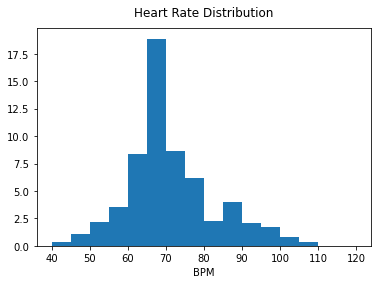

In [23]:
X = np.arange(42.5,122.5,5)
plt.bar(X, counts, width=5, align='center')
plt.title('Heart Rate Distribution', pad = 12)
plt.xlabel('BPM')
plt.show()

In order to study this distribution, we fit the count values to a gamma function.

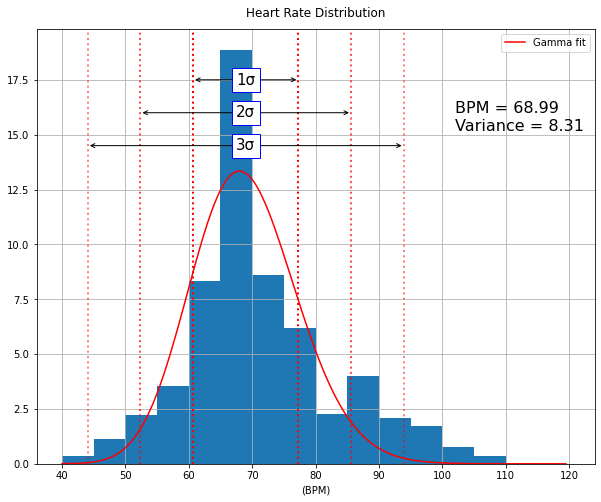

In [24]:
# Fit data to a gamma function
def gamma(x,c,amp):
    return amp*stats.gamma.pdf(x,c)

#initial values: most frequent heart beat given by Fourier analysis
popt, pcov = optimize.curve_fit(gamma, X, counts, p0 = (peak_freq,400))

# Plot
X_plot = np.arange(40,120,0.5)
plt.figure(figsize = (10,8))
plt.plot(X_plot, gamma(X_plot, *popt), color = 'red', label='Gamma fit')

plt.grid(True)
plt.legend()
plt.bar(X, counts, width=5, align='center')
plt.title('Heart Rate Distribution', pad = 12)
plt.xlabel('(BPM)')

#'''Remove the # if you don't want the gamma with the standard deviations
mean, var, skew, kurt = stats.gamma.stats(popt[0], moments = 'mvsk')
plt.axvline(x = mean + np.sqrt(var), linestyle = 'dotted',linewidth = 2,color = 'red')
plt.axvline(x = mean - np.sqrt(var),linestyle = 'dotted',linewidth = 2, color = 'red')
plt.axvline(x = mean + 2*np.sqrt(var), linestyle = 'dotted', linewidth = 2, color = 'red', alpha = 0.7)
plt.axvline(x = mean - 2*np.sqrt(var),linestyle = 'dotted',linewidth = 2, color = 'red', alpha = 0.7)
plt.axvline(x = mean + 3*np.sqrt(var), linestyle = 'dotted',linewidth = 2,color = 'red', alpha = 0.5)
plt.axvline(x = mean - 3*np.sqrt(var),linestyle = 'dotted',linewidth = 2, color = 'red', alpha = 0.5)
plt.annotate('', xy=(mean + np.sqrt(var),17.5), xytext=(mean - np.sqrt(var),17.5), arrowprops=dict(arrowstyle='<->'))
plt.annotate('', xy=(mean + 2*np.sqrt(var),16), xytext=(mean - 2*np.sqrt(var),16), arrowprops=dict(arrowstyle='<->'))
plt.annotate('', xy=(mean + 3*np.sqrt(var),14.5), xytext=(mean - 3*np.sqrt(var),14.5), arrowprops=dict(arrowstyle='<->'))
t = plt.text(mean, 17.5, "1σ", ha="center", va="center", rotation=0, size=15, bbox=dict(boxstyle="square, pad=0.3", fc="white", ec="b", lw=1))
t1 = plt.text(mean, 16, "2σ", ha="center", va="center", rotation=0, size=15, bbox=dict(boxstyle="square, pad=0.3", fc="white", ec="b", lw=1))
t2 = plt.text(mean, 14.5, "3σ", ha="center", va="center", rotation=0, size=15, bbox=dict(boxstyle="square, pad=0.3", fc="white", ec="b", lw=1))
#'''
plt.text(102, 15.2, f'BPM = {np.round(mean,2)}\nVariance = {np.round(np.sqrt(var),2)}', fontsize = 16)
plt.show()

The fit gives us a coherent estimation of the BPM. However, we can observe in the
plot that it is not completely satisfactory. Some counts around 90 are omitted by the fitting.
Therefore, we implement a second fitting.

The heartbeat of the subject changes in time and
our data was taken during approximately one minute. There exists the possibility
that the subject's heartbeat had more than one value (besides variability) over time.
In fact, if we look at HR over time in the plots above, we observe that
the frequency was higher and more unstable during the first 20 seconds, while later on
it became more stable and the subject had a slower heartbeat for the rest of the
measurement (majority of time). As a consequence, we fit our data to two gaussian curves
(the gamma function has showed us that gaussian is the appropriate fit for our data).
Each of the fittings will provide us with the most common heart rate in different moments of time.

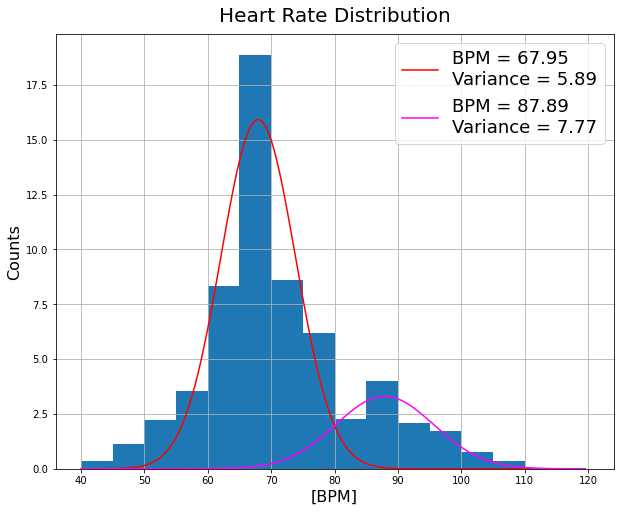

In [25]:
# Fit the histogram  to two gaussians
def gauss(x, amp, mu, sigma):
    return amp*np.exp(-0.5*((x - mu)/sigma)**2)

popt1, pcov1 = optimize.curve_fit(gauss, X, counts, p0 = (20, peak_freq, 5))
popt2, pcov2 = optimize.curve_fit(gauss, X[8:], counts[8:], p0 = (0, 90, 5))

# Plot
plt.figure(figsize = (10,8))
plt.plot(X_plot, gauss(X_plot, *popt1), color = 'red', label=f'BPM = {np.round(popt1[1],2)}\nVariance = {np.round(popt1[2],2)}')
plt.plot(X_plot, gauss(X_plot, *popt2), color = 'magenta', label=f'BPM = {np.round(popt2[1],2)}\nVariance = {np.round(popt2[2],2)}')
plt.grid(True)
plt.legend(fontsize = 18)

plt.bar(X, counts, width=5, align='center')
plt.title('Heart Rate Distribution', pad = 12, fontsize = 20)
plt.ylabel('Counts', fontsize = 16)
plt.xlabel('[BPM]', fontsize = 16)
plt.show()

#### Heart Rate Variability

Finally, lets study the Heart Rate Variability. This parameter is important because
in healthy hearts there is a natural variation on the heart beat given by a
balance between the sympathetic nervous system (SNS) and parasympathetic
parts (PSNS) of the Autonomous Nervous System. These systems control our response
to stress and our relaxation response, respectively. They are usually in a healthy balance,
causing natural HRV. However, if the balance is disturbed the variance will change; which
could be associated to stress and various illnesses. (Source: https://www.health.harvard.edu)

In [26]:
HRV_total = 0
for i in HRV:
    HRV_total += HRV[i]*weights[i]/info_PC

print("The HRV of the subject is:", np.round(HRV_total*1000,2), "ms.")

The HRV of the subject is: 179.81 ms.


# CONCLUSIONS

Brief summary of the previous steps:

we have developed an algorithm that allows, starting with 9 different signals, to select the most useful information and remove the noise, in order to obtain a clean signal that would allow us to estimate the distribution of the HR and its variance.
To do this we initially applied a PCA (variance conteined 80%) and then passed the signals through two filters: a bandpass and a wavelet. obtained the final signals we used the scipy.signal function to implement a function that collected the peak-to-peak distances within a histogram. Once we performed a Gaussian fit on the histogram we obtained the average value and the variance.

This process was performed on two different datasets: "center_sternum.txt", SCG tecnique, and "4_chest_sweater, a BCG tecnique".

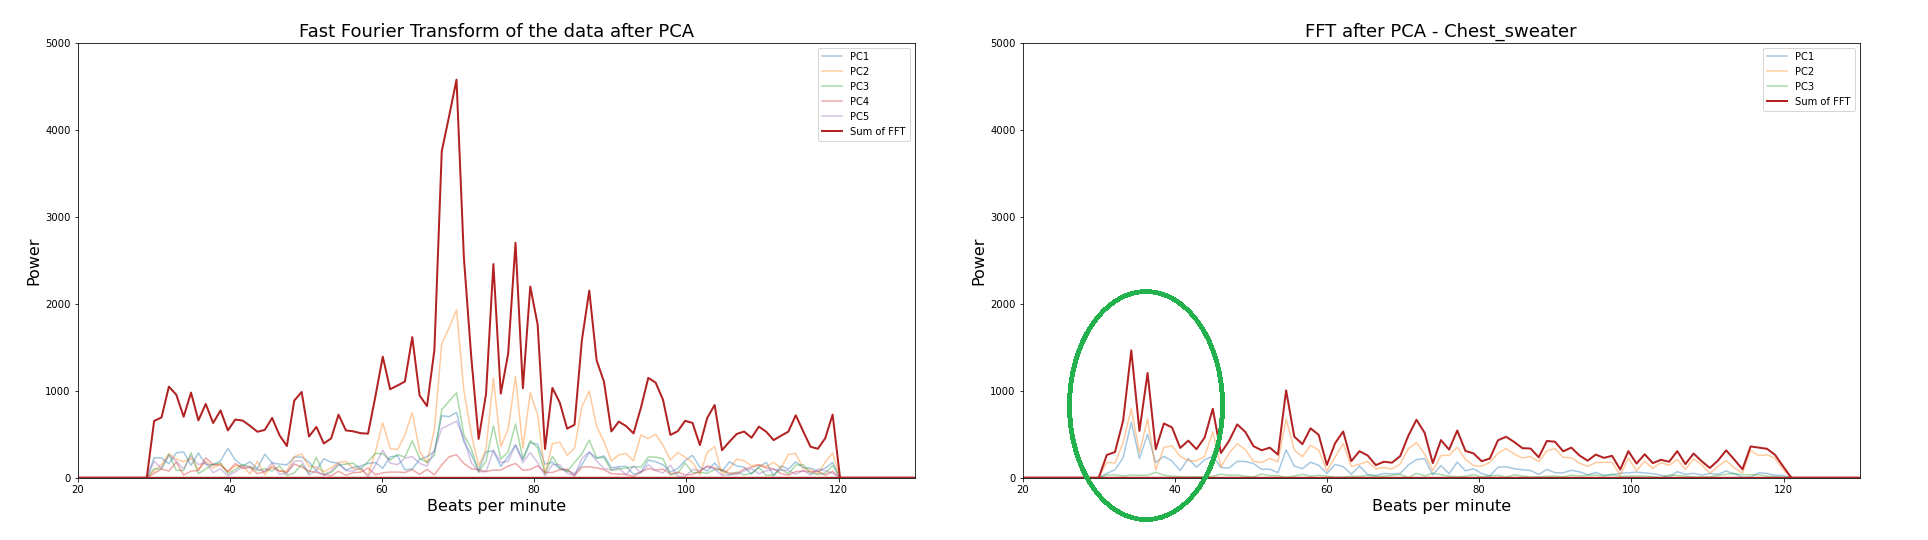

In [27]:
Image('FFT after PCA.png')

as reported in scientific researches (i.e. https://pubmed.ncbi.nlm.nih.gov/25571385/) the BCG, due to the material between the patient and the sensor, tends to record a signal composed of more low frequencies. Since a healthy patient has a BPM between 40 and 100, we decided to adopt this hypothesis and still cut the frequencies below 40 Hz also for the second dataset.

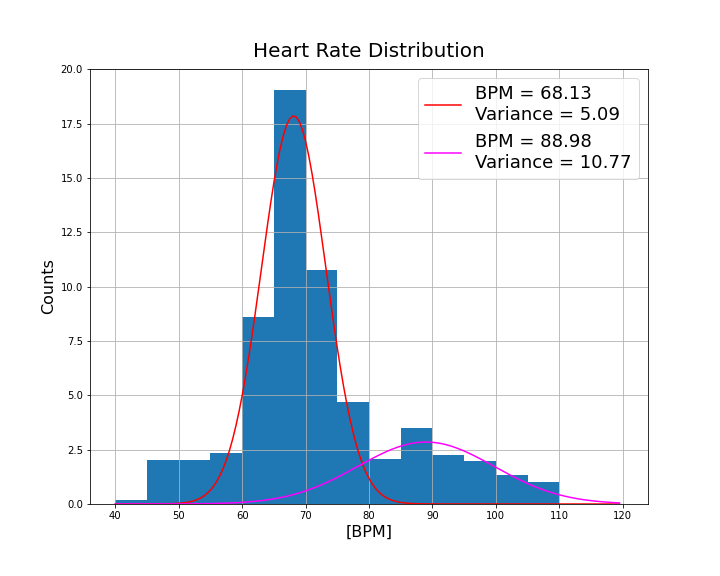

In [28]:
# Load images from final result of both datasets
Image("HRdistribution_data1.png")

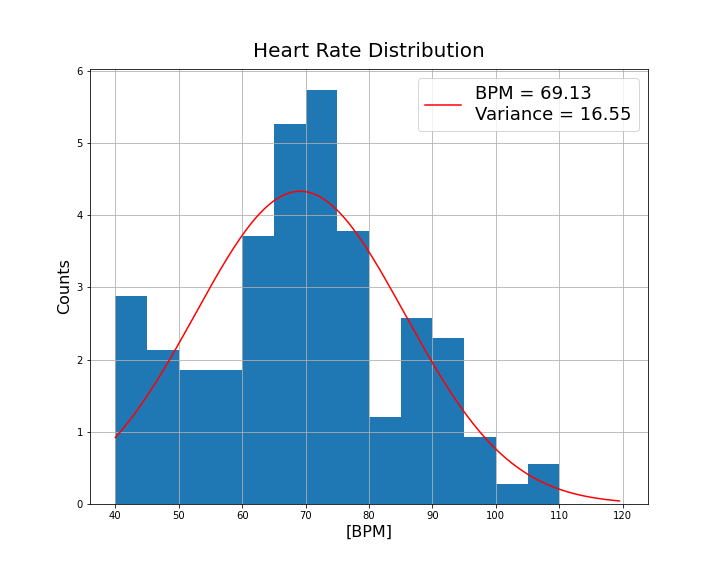

In [29]:
Image('HRdistribution_data4.png')

As we can see from the two distributions (the first relating to the SCG, the second to the BCG) the average value of the HR is between 68-70 BPM for both, this suggests a correct functioning of the filters and of the detection of the peaks (and consequently of the distance peak-to-peak). it can be seen that the standard deviation of the two distributions is significantly different: in BCG it is larger. This can be interpreted as a direct consequence of an indirect measurement system: in fact in the BCG the sensor is placed on the sweater, rather than directly on the patient's skin, and this causes much more uncertainty in the measurement of the signals.

Below are the HRV values for both measurements:

In [30]:
# Load HRV of both datasets
HRV_data1 = np.loadtxt('HRV_data1')
HRV_data4 = np.loadtxt('HRV_data4')

print("HRV (center sternum) = ", np.round(HRV_data1*1000,2), "ms.")
print("HRV (chest sweater) = ", np.round(HRV_data4*1000,2), "ms.")

HRV (center sternum) =  198.33 ms.
HRV (chest sweater) =  292.65 ms.
